In [1]:
import json
import os
import subprocess
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [12]:
def reformat_newick(cov, gene):
    if cov=='229e' or cov=='nl63':
        lineages = ['']
    else:
        lineages = ['A','B']
    
    new_lines = []
    with open('../'+str(cov)+'/results/tree_'+str(cov)+'_'+gene+'.nwk', 'r') as input_newick:
        for line in input_newick.readlines():
            new_lines.append(line.replace('/','-').replace(str(cov), str(cov).upper()))
    for lineage in lineages:
        pact_analysis_path = '../../../PACT/'+str(cov)+str(lineage)+'/'+str(cov)+str(lineage)+'_'+str(gene)
        if path.exists(pact_analysis_path):
            with open(pact_analysis_path+'/in.trees', 'w') as output_newick:
                output_newick.writelines(new_lines)
        else:
            os.makedirs(pact_analysis_path)
            with open(pact_analysis_path+'/in.trees', 'w') as output_newick:
                output_newick.writelines(new_lines)

In [13]:
def find_lineages(cov, gene):
    
    if cov=='229e' or cov=='nl63':
        lineage = ''
        lineage_tips = False
        write_param_file(cov, lineage, gene, lineage_tips)
        
    else:
        lineages = ['A','B']
    
        if cov == 'hku1':
            clade_file = '../'+str(cov)+'/results/clades_full.json'
        else:
            if gene =='spike':
                clade_file = '../'+str(cov)+'/results/clades_spike.json'
            elif gene == 's1':
                clade_file = '../'+str(cov)+'/results/clades_s1.json'
            elif gene == 's2':
                clade_file = '../'+str(cov)+'/results/clades_s2.json'd
            elif gene == 'rdrp':
                clade_file = '../'+str(cov)+'/results/clades_rdrp.json'
            else:
                clade_file = '../'+str(cov)+'/results/clades_full.json'    

        for lineage in lineages:
            lineage_tips = []
            with open(clade_file, "r") as clade_handle:
                clades = json.load(clade_handle)
                for node, v in clades['nodes'].items():
                    if 'NODE' not in node:
                        if v['clade_membership'] == lineage:
                            lineage_tips.append(node)

            write_param_file(cov, lineage, gene, lineage_tips)

In [28]:
def write_param_file(cov, lineage, gene, lineage_tips):
    
    min_years = {'oc43A': 1990, 'oc43B': 1987, '229e': 1989, 'hku1A': 2005, 'hku1B': 2005, 'nl63': 1983}
    max_years = {'oc43A': 2019, 'oc43B': 2019, '229e': 2019, 'hku1A': 2016, 'hku1B': 2017, 'nl63': 2019}
    
    with open('../../../PACT/'+str(cov)+str(lineage)+'/'+str(cov)+str(lineage)+'_'+gene+'/in.param', 'w') as param_file:
        param_file.write(f'push times back {min_years[str(cov)+str(lineage)]} {max_years[str(cov)+str(lineage)]}\n')
        if lineage_tips:
            param_file.write('prune to tips')
            for x in lineage_tips:
                tip = ' ' +x.replace('/','-').replace(str(cov), str(cov).upper())
                param_file.write(tip)
            param_file.write('\n')
        param_file.write(f'print rule tree\nsummary settings {min_years[str(cov)+str(lineage)]} {max_years[str(cov)+str(lineage)]} 0.5\nsummary tmrca\nsummary diversity\nskyline settings {min_years[str(cov)+str(lineage)]} {max_years[str(cov)+str(lineage)]} 0.5\nskyline tmrca\nskyline diversity')


In [15]:
def run_pact(cov, gene):
    reformat_newick(cov, gene)
    find_lineages(cov, gene)
    
    if cov=='229e' or cov=='nl63':
        lineages = ['']   
    else:
        lineages = ['A','B']
    
    for lineage in lineages:
        cov_lineage_directory = f"../../../PACT/{cov}{lineage}/{cov}{lineage}_{gene}"
        subprocess.Popen("cp ../../pact .", cwd= cov_lineage_directory, 
                         shell=True, stdin = subprocess.PIPE, stdout = subprocess.PIPE)
        subprocess.Popen("./pact", cwd= cov_lineage_directory, 
                         shell=True, stdin = subprocess.PIPE, stdout = subprocess.PIPE)
        

In [64]:
covs = ['229e', 'oc43', 'nl63', 'hku1']
genes = ['spike', 's1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid', 'rdrp', 'envelope']

for cov in covs:
    for gene in genes:
        run_pact(cov, gene)

In [9]:
def import_pact_results(cov, genes):
    
    if cov=='229e' or cov=='nl63':
        lineages = ['']
    else:
        lineages = ['A','B']
    
    df_tmrca = pd.DataFrame()
    df_diversity = pd.DataFrame()
    
    
    for lineage in lineages:
        for gene in genes:

            df_gene = pd.read_csv('../../../PACT/'+str(cov)+str(lineage)+'/'+str(cov)+str(lineage)+'_'+gene+'/out.skylines', sep='\t')
            df_gene['gene'] = gene
            df_gene['cov'] = cov
            df_gene['lineage'] = lineage
            df_t = df_gene[df_gene['statistic']=='tmrca']
            df_d = df_gene[df_gene['statistic']=='div']
            df_tmrca = df_tmrca.append(df_t)
            df_diversity = df_diversity.append(df_d)

    return df_tmrca, df_diversity

In [68]:
def plot_pact_results(stat, cov, genes):
    
    df_tmrca, df_diversity = import_pact_results(cov, genes)
    
    sns.set(font_scale=2)
    sns.set_style("white")
    
    if stat == 'tmrca':
        g = sns.FacetGrid(df_tmrca, row = 'lineage', hue='gene', height = 6, aspect = 3)
#         g = (g.map(plt.plot, 'time', 'mean', lw=6).add_legend())
        g = (g.map(plt.scatter, 'time', 'mean', lw=6).add_legend())
    
    elif stat == 'diversity':
        g = sns.FacetGrid(df_diversity, row = 'lineage', hue='gene', height = 6, aspect = 3)
        g = (g.map(plt.plot, 'time', 'mean', lw=6).add_legend())
        
#     g.fig.subplots_adjust(top=0.8)
#     g.fig.suptitle(str(cov), fontsize=30)
    

In [74]:
##Need to exclude old sequences and rooting sequences

def avg_tmrca_table(covs, genes):
    
    avg_tmrca = []

    for cov in covs:
        if cov=='229e' or cov=='nl63':
            lineages = ['']
        else:
            lineages = ['A','B']
    
        
        for gene in genes:

            df_tmrca, df_diversity = import_pact_results(cov, [str(gene)])
            
            for lineage in lineages:
                lineage_df_tmrca = df_tmrca[df_tmrca['lineage']==lineage]
                lineage_df_tmrca = lineage_df_tmrca.dropna()

                lineage_gene_avg_tmrca = lineage_df_tmrca['mean'].mean()

                avg_tmrca.append({'gene': gene, 'cov': cov, 'lineage': lineage, 
                                  'mean_tmrca': lineage_gene_avg_tmrca})


    df_avg_tmrca = pd.DataFrame(avg_tmrca)
    
    
    print(df_avg_tmrca)

In [75]:
avg_tmrca_table(['oc43', '229e'], ['spike', 's1', 's2', 'rdrp', 'membrane', 'replicase1ab', 'envelope'])

            gene   cov lineage  mean_tmrca
0          spike  oc43       A   15.385549
1          spike  oc43       B   48.131409
2             s1  oc43       A    3.453473
3             s1  oc43       B   19.376093
4             s2  oc43       A    7.291065
5             s2  oc43       B   10.961919
6           rdrp  oc43       A    9.696667
7           rdrp  oc43       B    2.111315
8       membrane  oc43       A    2.462072
9       membrane  oc43       B    1.636527
10  replicase1ab  oc43       A    6.269476
11  replicase1ab  oc43       B    1.071436
12      envelope  oc43       A   13.224119
13      envelope  oc43       B    6.082325
14         spike  229e            4.191611
15            s1  229e            2.225598
16            s2  229e            5.081813
17          rdrp  229e            4.400021
18      membrane  229e            7.591995
19  replicase1ab  229e            4.480188
20      envelope  229e           14.164690


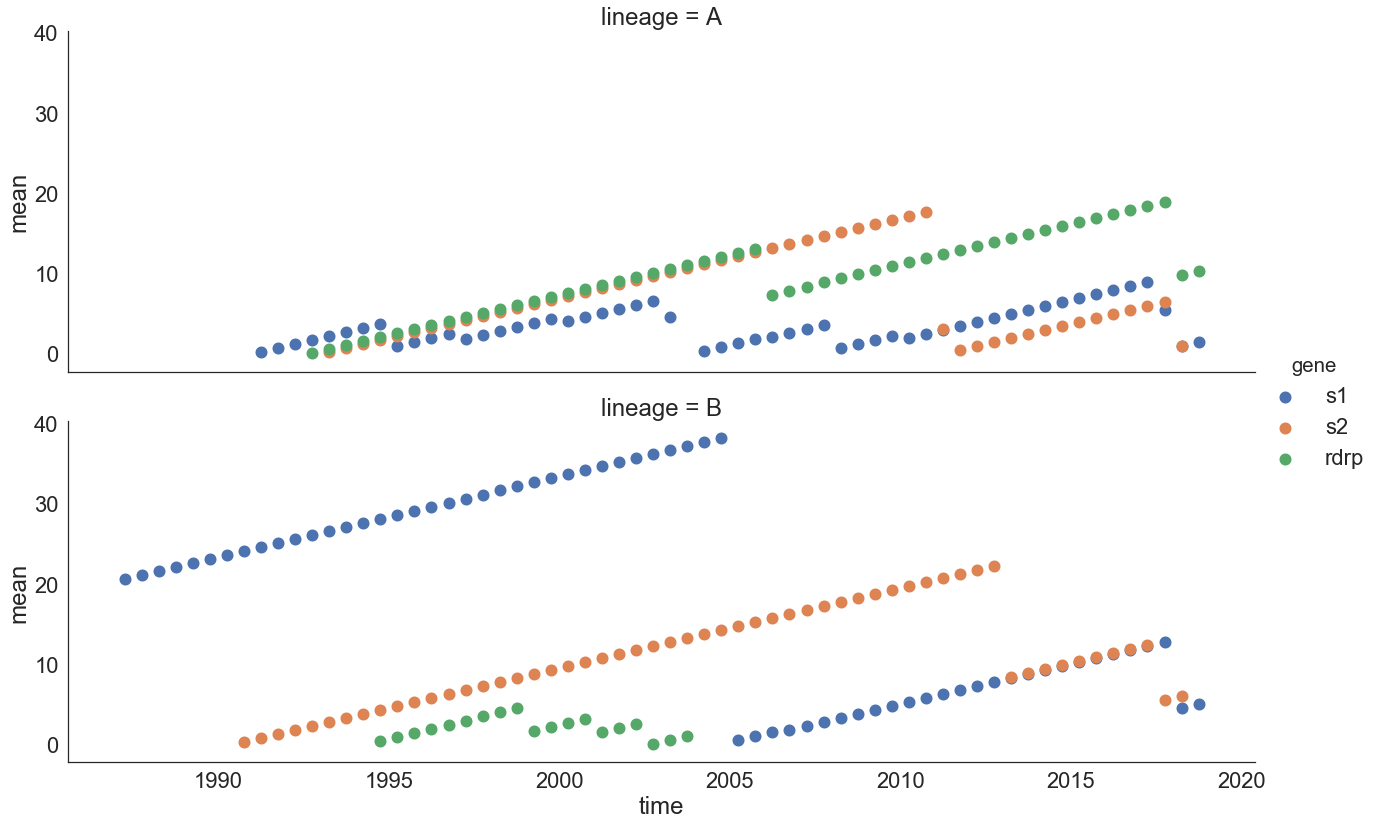

In [69]:
plot_pact_results('tmrca','oc43', ['s1', 's2', 'rdrp'])

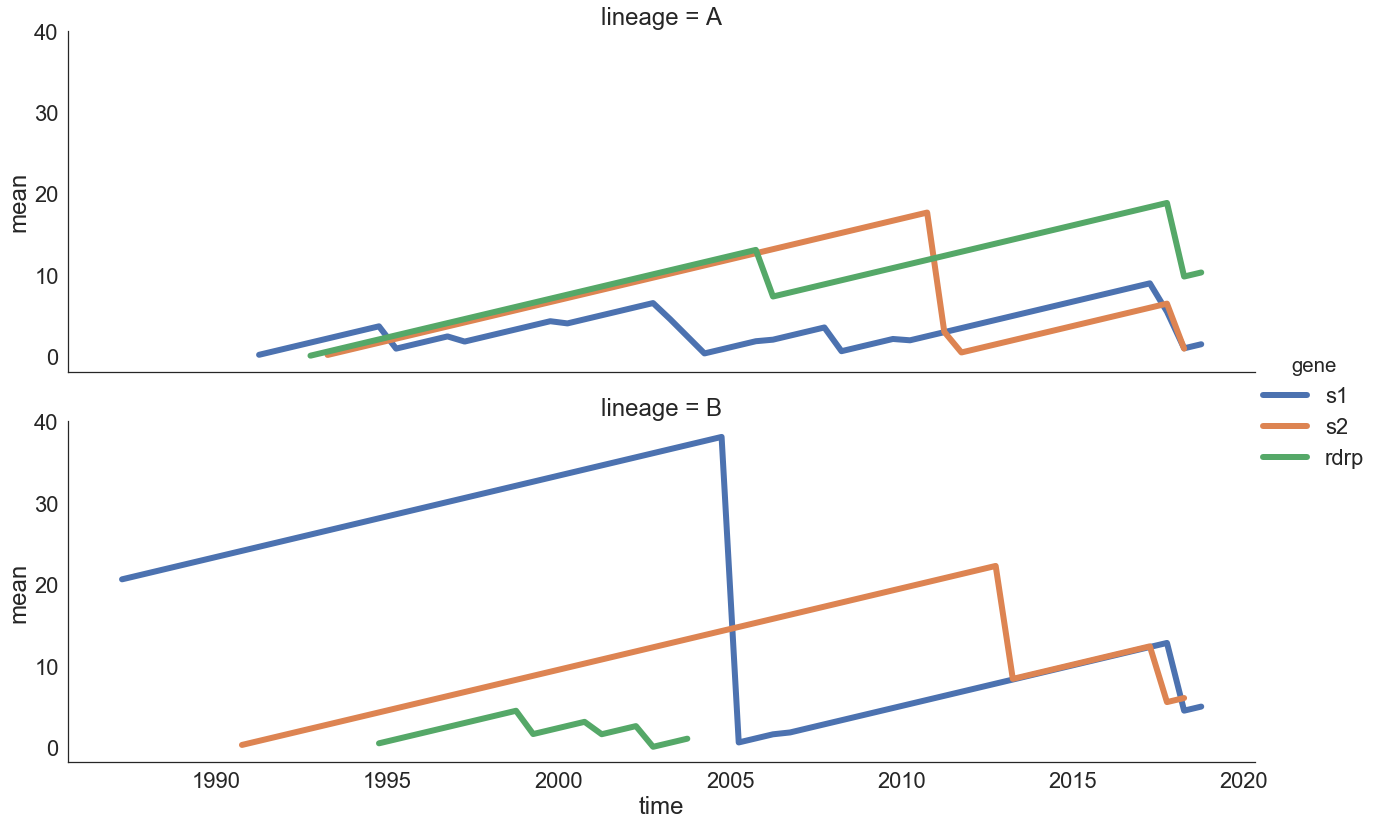

In [46]:
plot_pact_results('tmrca','oc43', ['s1', 's2', 'rdrp'])

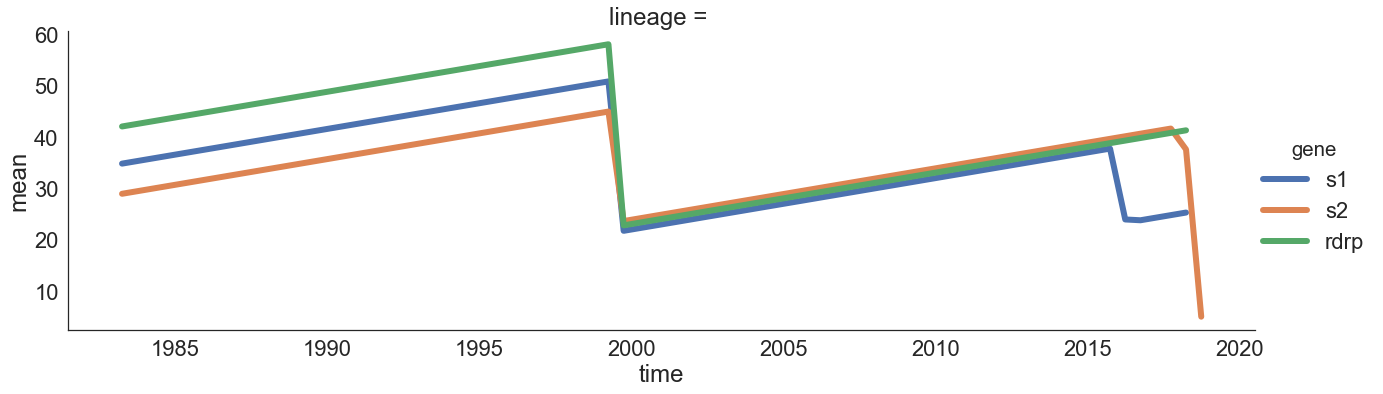

In [19]:
plot_pact_results('tmrca','nl63', ['s1', 's2', 'rdrp'])

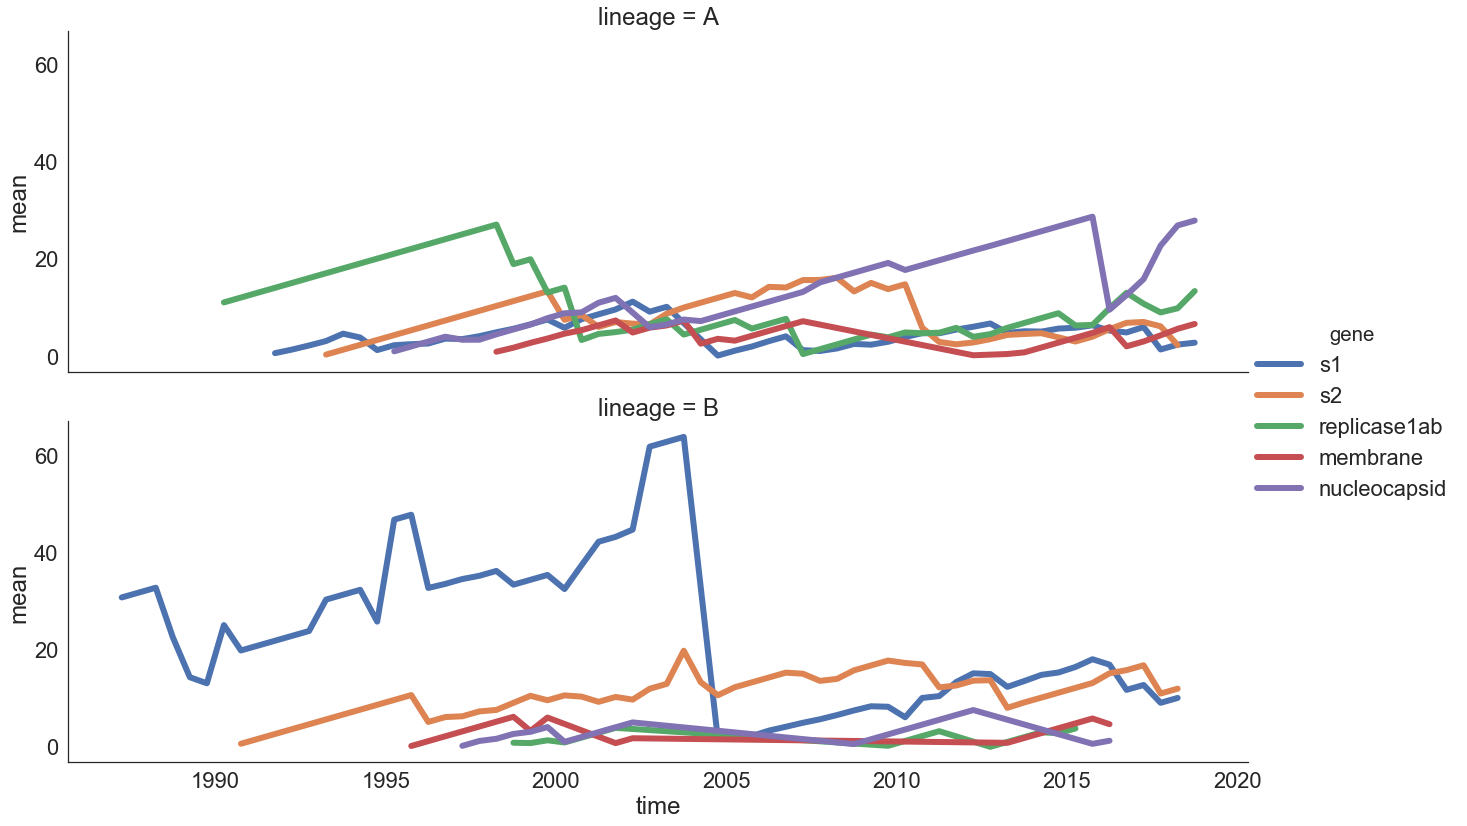

In [428]:
plot_pact_results('diversity','oc43', ['s1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid'])

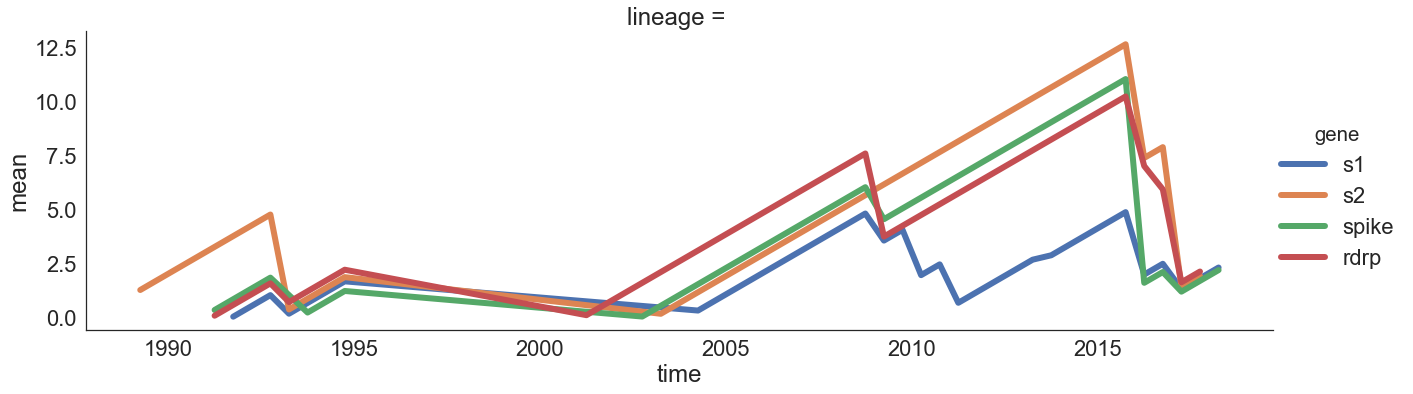

In [14]:
plot_pact_results('tmrca','229e', ['s1', 's2', 'spike', 'rdrp'])

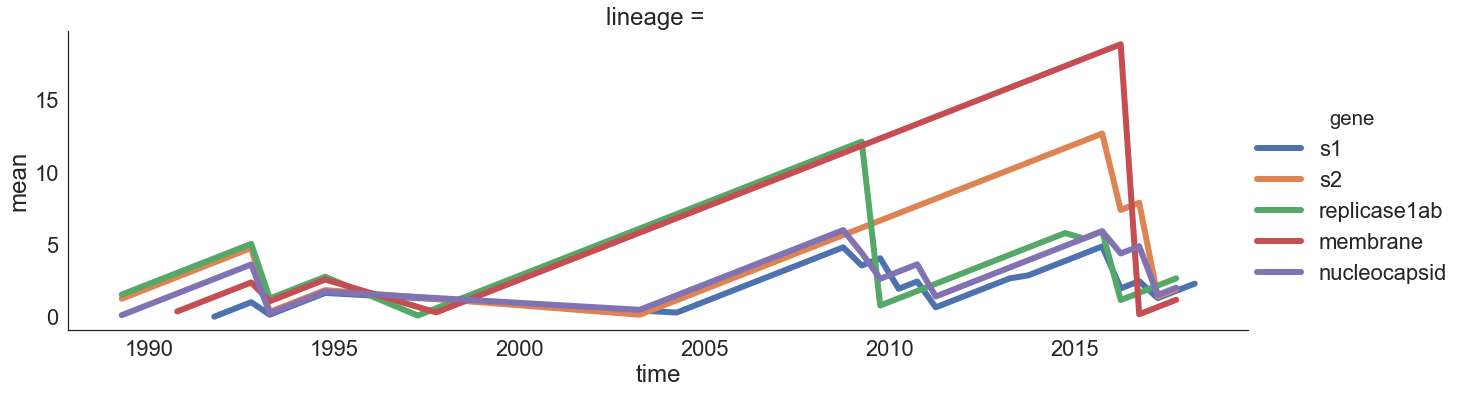

In [13]:
plot_pact_results('tmrca','229e', ['s1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid'])

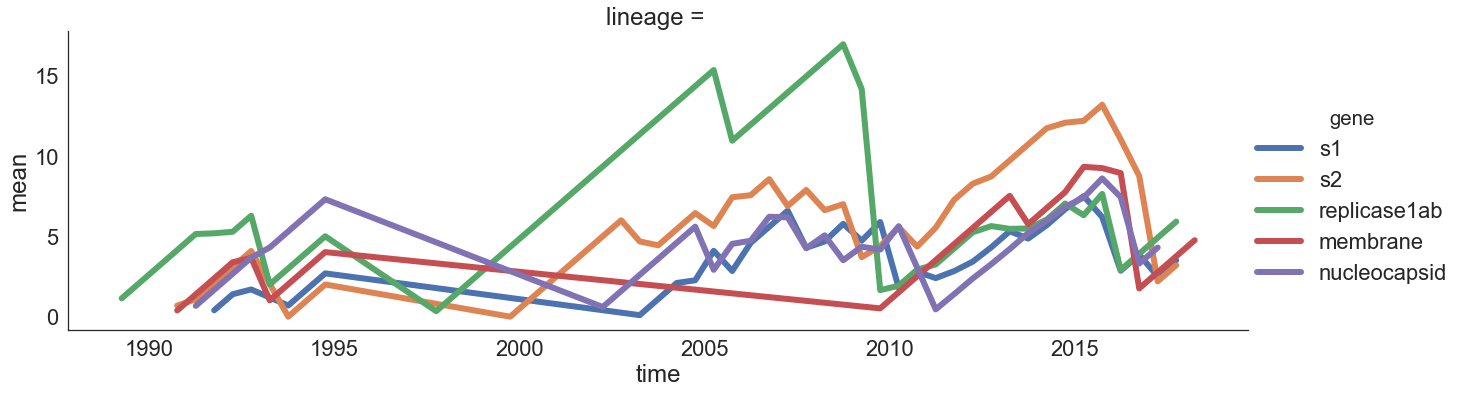

In [430]:
plot_pact_results('diversity','229e', ['s1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid'])

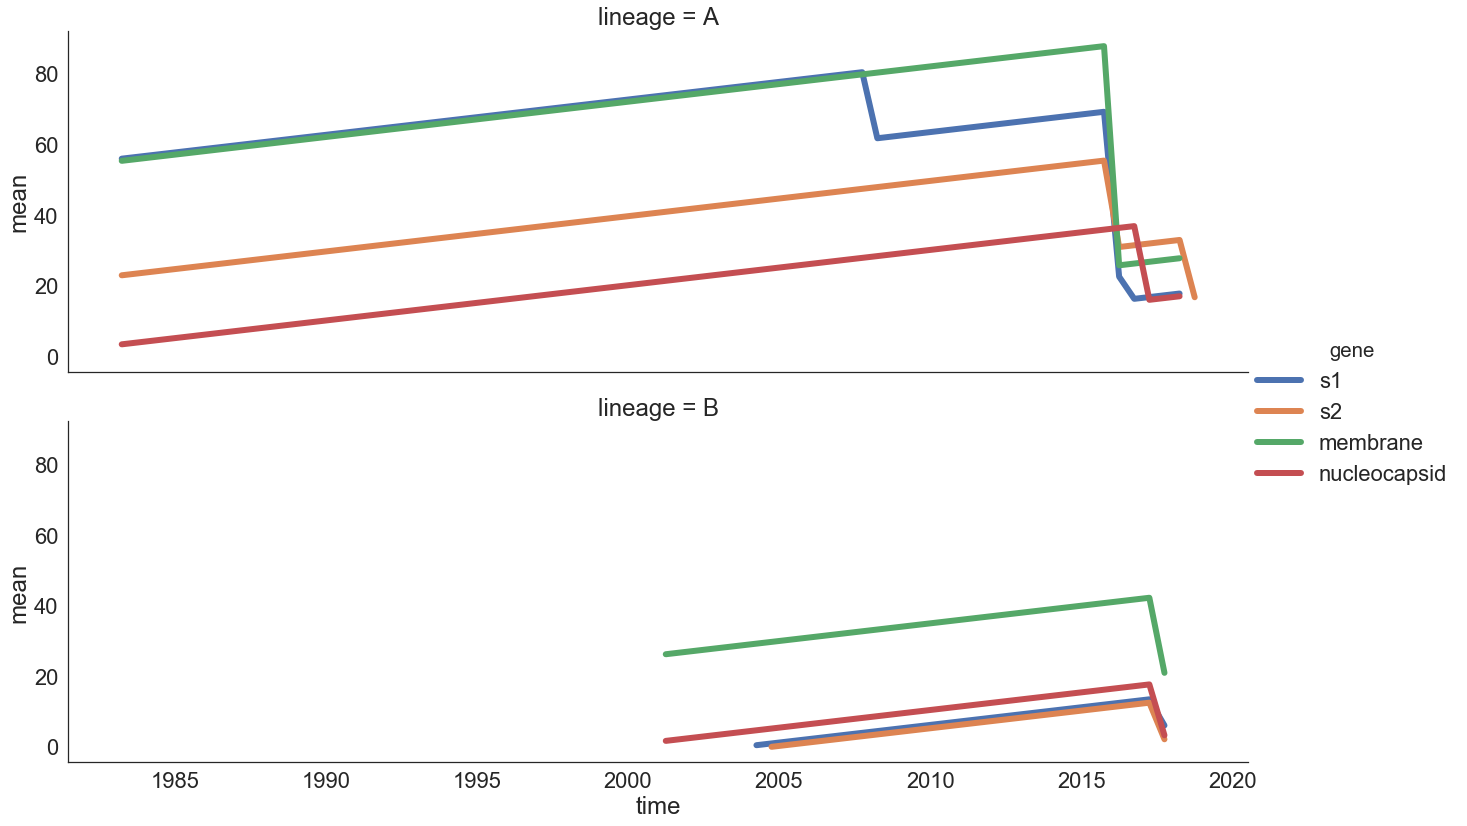

In [431]:
plot_pact_results('tmrca','nl63', ['s1', 's2', 'membrane', 'nucleocapsid'])

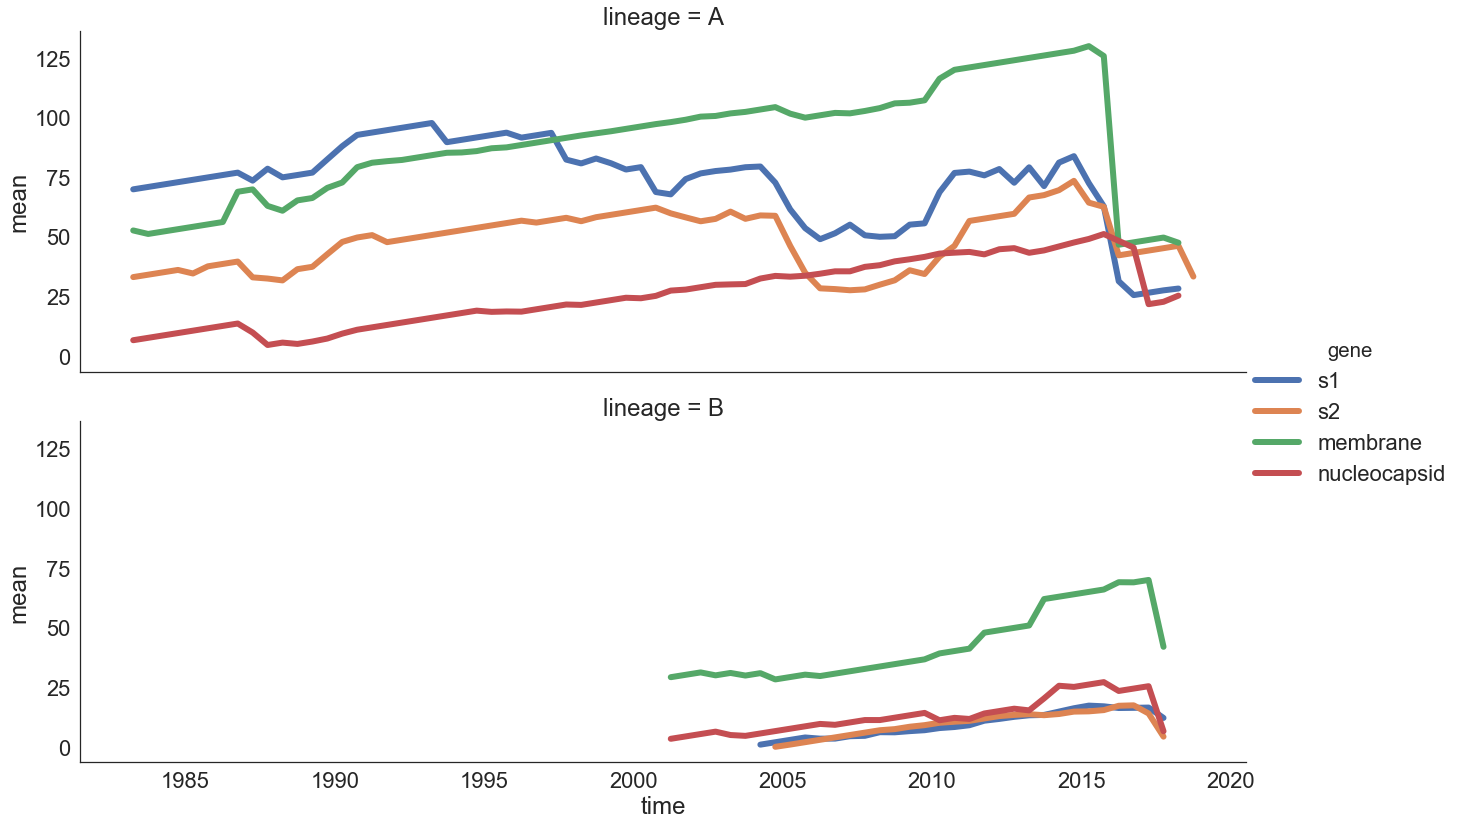

In [432]:
plot_pact_results('diversity','nl63', ['s1', 's2', 'membrane', 'nucleocapsid'])

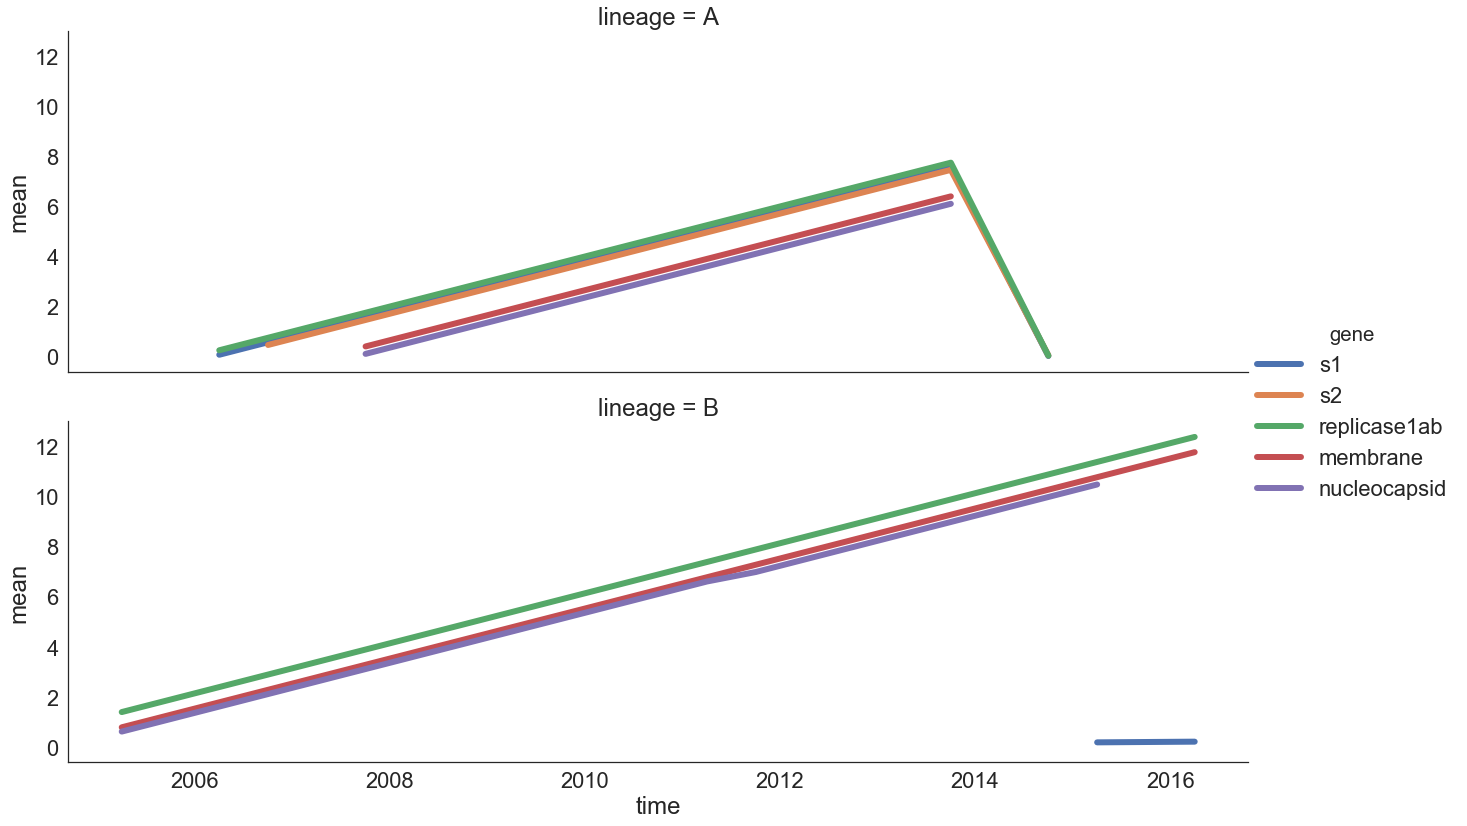

In [433]:
plot_pact_results('tmrca','hku1', ['s1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid'])

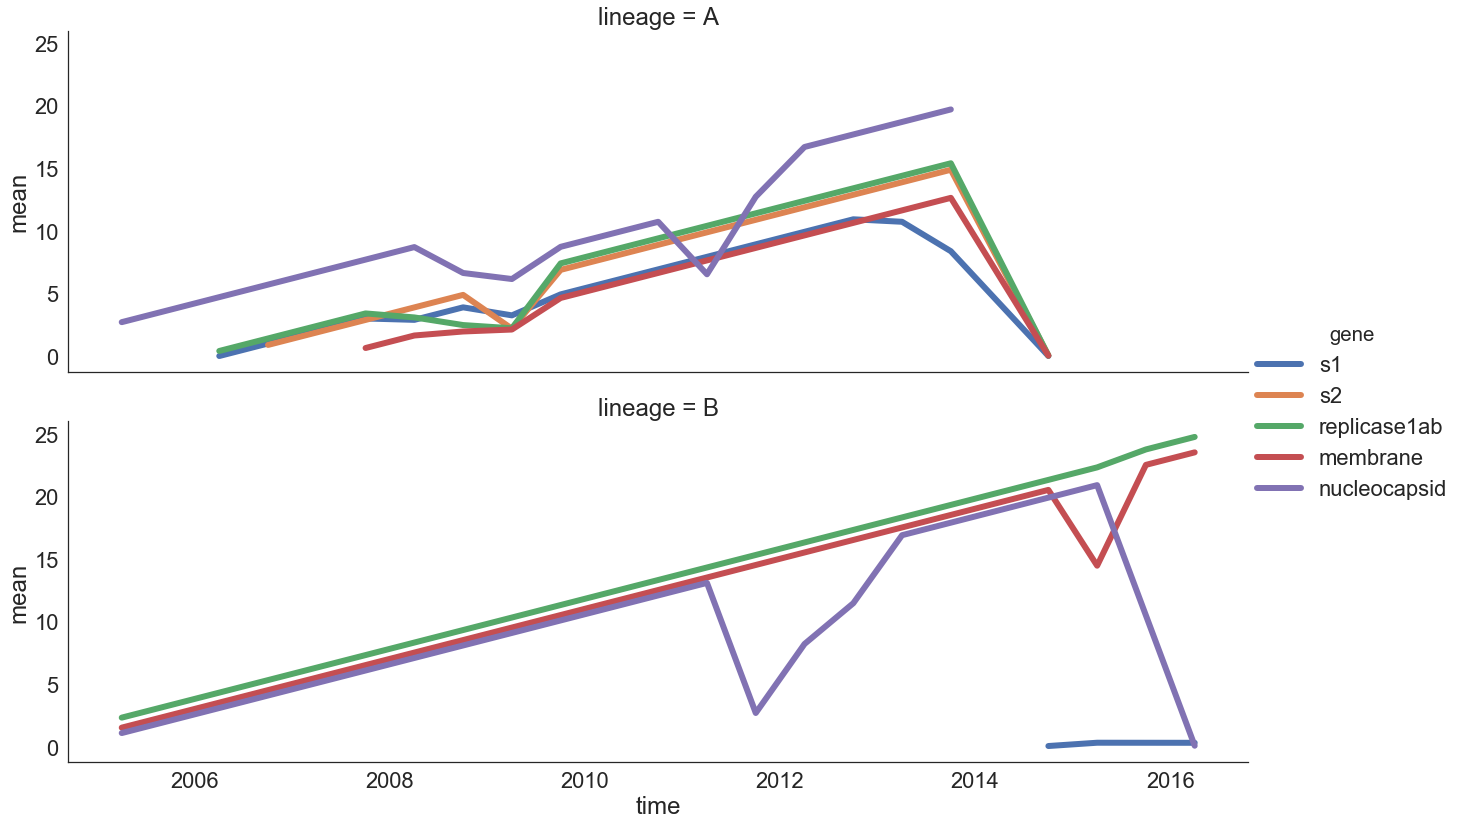

In [76]:
plot_pact_results('diversity','hku1', ['s1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid'])